# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import tqdm

In [2]:
import sys
import os

# File path to the src directory for both linux and windows
# workaround for the issue of relative imports in Jupyter notebooks to import modules from src without using the full path
src_path = os.path.abspath("src")
if src_path not in sys.path:
    sys.path.insert(0, src_path)

In [40]:
# Rerun this cell after making changes to the utils module
from the_team.utils import etl
import importlib
importlib.reload(etl)

# Set custom plot style for consistency
etl.set_plot_style()

Custom plot style set.


# Before Cleaning

In [4]:
RAW_DIR = Path("data") / "01_raw"

In [20]:
# Load datasets
customers = etl.load_csv(RAW_DIR / "olist_customers_dataset.csv")
geolocation = etl.load_csv(RAW_DIR / "olist_geolocation_dataset.csv")
items = etl.load_csv(RAW_DIR / "olist_order_items_dataset.csv")
payments = etl.load_csv(RAW_DIR / "olist_order_payments_dataset.csv")
reviews = etl.load_csv(RAW_DIR / "olist_order_reviews_dataset.csv")
orders = etl.load_csv(RAW_DIR / "olist_orders_dataset.csv")
products = etl.load_csv(RAW_DIR / "olist_products_dataset.csv")
sellers = etl.load_csv(RAW_DIR / "olist_sellers_dataset.csv")
translation = etl.load_csv(RAW_DIR / "product_category_name_translation.csv")

### Geolocation-related datasets [Jin Bin]
- customers.csv
- geolocation.csv
- sellers.csv

### Review-related datasets [Habib]
- review.csv
- products.csv
- translation.csv

### Order-related datasets [Min]
- items.csv
- payments.csv
- orders.csv

#### items.csv

In [21]:
items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [22]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [23]:
# df info says no Null but still; Null and duplicate check
etl.null_duplicate_check(items)

No null values found.
No duplicates found.


In [ ]:
# 1. shipping_limit_date has wrong data type.
items["shipping_limit_date"] = pd.to_datetime(items["shipping_limit_date"], format="%Y-%m-%d %H:%M:%S")
assert items["shipping_limit_date"].dtype == "datetime64[ns]", "shipping_limit_date should be datetime64[ns]"

# 2. order_id has wrong data type, but it's not useful for our business goal since it's just indexing items in an order.
# Thus, we can drop it.
items.drop(columns=["order_item_id"], inplace=True)

# Some duplicates are expected after dropping order_item_id, since there can be multiple items in an order.
# Left untreated as these duplicates are identifiable and workable with the order_id.
etl.null_duplicate_check(items)

No null values found.
Duplicates found.
9.08% or 10225 rows are complete duplicates


In [25]:
# Check distribution of numeric columns
items.describe()

,shipping_limit_date,price,freight_value
count,112650,112650.000000,112650.000000
mean,2018-01-07 15:36:52.192685312,120.653739,19.990320
min,2016-09-19 00:15:34,0.850000,0.000000
25%,2017-09-20 20:57:27.500000,39.900000,13.080000
50%,2018-01-26 13:59:35,74.990000,16.260000
75%,2018-05-10 14:34:00.750000128,134.900000,21.150000
max,2020-04-09 22:35:08,6735.000000,409.680000
std,NaN,183.633928,15.806405


- A large gap between the 75th percentile (Q3) and the maximum indicates that there are high-value outliers. 
- Olist dataset distributor mentioned (in Kaggle) that the data is from 2016 to 2018.

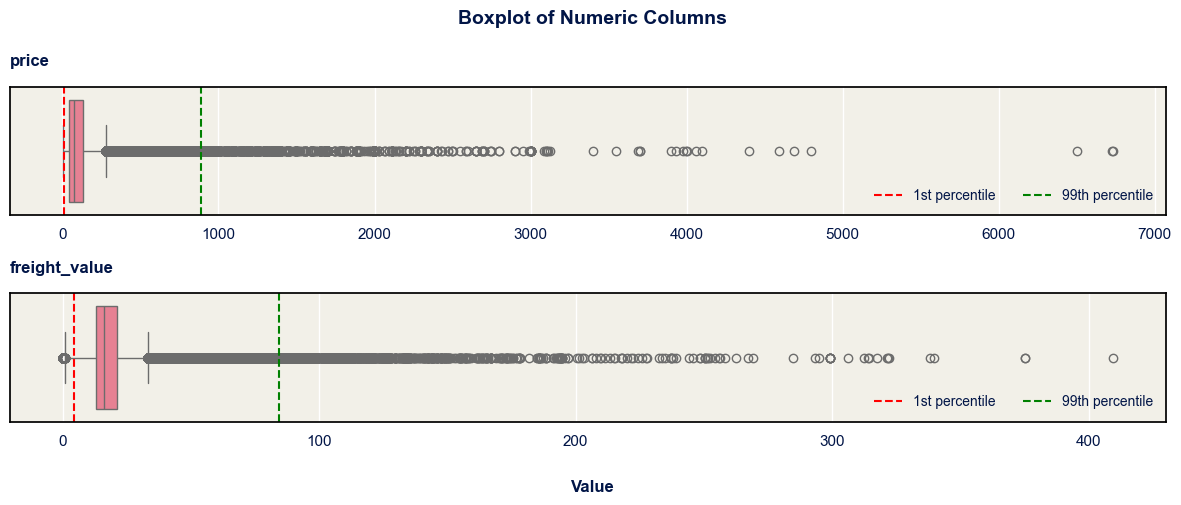

In [30]:
# 3. Drop rows not within 2016-2018
items = items[items["shipping_limit_date"].dt.year.isin([2016, 2017, 2018])]

# Plot distribution of numeric columns
etl.plot_numeric_distribution(items)

- Both price & freight_value columns show strong right-skewed distributions with a large number of high-value outliers, which is expected as people mostly buy FMCGs (with low cost) from online, not high-end products.
- Right-skewed price means the item is expensive while right-skewed freight_value means either the customer lives far away from sellers or the item is physically huge; this can be cross-checked later with geolocation and product data.

In [37]:
price_99p = items['price'].quantile(0.999)
print(f"99.9% of price is ${price_99p}.")
freight_99p = items['freight_value'].quantile(0.999)
print(f"99.9% of freight_value is ${freight_99p:.2f}.")

99.9% of price is $2110.0.
99.9% of freight_value is $175.59.


High values in both price and freight_value are important as they may suggest:
- People who bought expensive quality producuts are less likely to buy again. 
- People who have to pay high freight_value are less likely to buy again. 
But, capturing 99.9% of current customers should be representative enough. 

In [41]:
# 4. Remove outliers
items['price'] = etl.cap_outliers(items['price'], min_cap=False, max_cap=99.9)
items['freight_value'] = etl.cap_outliers(items['freight_value'], min_cap=False, max_cap=99.9)

In [42]:
# 5. Flag high values for the model to learn that a price/freight is unusually high
items['price_high'] = items['price'] > price_99p
items['freight_value_high'] = items['freight_value'] > freight_99p

#### orders.csv